In [18]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from sklearn.model_selection import train_test_split

In [19]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [20]:
device = 'cuda'
num_steps = 400
batch_size = 8512
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [21]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('CPPN64.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [22]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

#### Map spacial coordinates

In [23]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []

def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
    
        normal = normalize_minus1_to_1(temp_coords)
        normal = torch.nan_to_num(normal, nan = 0)
        if index == 2:
            print(temp_coords)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)
# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

# print(layer1_arragned)
    
    # getting seemingly random output here 
        

tensor([[ 2.,  0.,  3.,  0.],
        [ 2.,  1.,  3.,  0.],
        [ 2.,  2.,  3.,  0.],
        [ 2.,  3.,  3.,  0.],
        [ 2.,  4.,  3.,  0.],
        [ 2.,  5.,  3.,  0.],
        [ 2.,  6.,  3.,  0.],
        [ 2.,  7.,  3.,  0.],
        [ 2.,  8.,  3.,  0.],
        [ 2.,  9.,  3.,  0.],
        [ 2., 10.,  3.,  0.],
        [ 2., 11.,  3.,  0.],
        [ 2., 12.,  3.,  0.],
        [ 2., 13.,  3.,  0.],
        [ 2., 14.,  3.,  0.],
        [ 2., 15.,  3.,  0.],
        [ 2., 16.,  3.,  0.],
        [ 2., 17.,  3.,  0.],
        [ 2., 18.,  3.,  0.],
        [ 2., 19.,  3.,  0.],
        [ 2., 20.,  3.,  0.],
        [ 2., 21.,  3.,  0.],
        [ 2., 22.,  3.,  0.],
        [ 2., 23.,  3.,  0.],
        [ 2., 24.,  3.,  0.],
        [ 2., 25.,  3.,  0.],
        [ 2., 26.,  3.,  0.],
        [ 2., 27.,  3.,  0.],
        [ 2., 28.,  3.,  0.],
        [ 2., 29.,  3.,  0.],
        [ 2., 30.,  3.,  0.],
        [ 2., 31.,  3.,  0.],
        [ 2., 32.,  3.,  0.],
        [ 

#### Set up CPPN_squared

In [24]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 16)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64,64)

      self.fc3 = nn.Linear(16, 1)     

    #   self.init_weights()
      
    # def init_weights(self):
    #   for m in self.modules():
    #       if isinstance(m, nn.Linear):
    #           # Initialize weights using Xavier initialization
    #           init.xavier_normal_(m.weight)
    #           # Initialize biases to zeros
    #           init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = torch.sin(x)
        # x = F.relu(x)

        x = self.fc2(x)
        x = torch.sin(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [25]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [26]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [27]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([0.6861, 0.5461, 0.3091, 0.1511, 0.7882, 0.1739, 0.1498, 0.6432, 0.7128,
        0.4255, 0.1945, 0.5213, 0.1559, 0.8248, 0.3977, 0.6664, 0.5885, 0.2722,
        0.4565, 0.1575, 0.3445, 0.7694, 0.6490, 0.4748, 0.5470, 0.5634, 0.2457,
        0.7900, 0.7181, 0.4206, 0.2106, 0.3687, 0.7248, 0.7219, 0.5703, 0.8126,
        0.6854, 0.1865, 0.7338, 0.3291, 0.5491, 0.6727, 0.5367, 0.1830, 0.3568,
        0.7521, 0.4535, 0.8155, 0.3323, 0.3309, 0.4150, 0.2368, 0.2341, 0.5518,
        0.8094, 0.3344, 0.3743, 0.5111, 0.6742, 0.5439, 0.6926, 0.5797, 0.5053,
        0.6082, 0.1894, 0.8139, 0.8456, 0.6910, 0.7833, 0.1893, 0.3118, 0.6742,
        0.5245, 0.7819, 0.5077, 0.2491, 0.2820, 0.3624, 0.2938, 0.8247, 0.4981,
        0.4294, 0.1898, 0.7893, 0.5236, 0.6919, 0.2669, 0.3839, 0.6883, 0.1865,
        0.6995, 0.5657, 0.2515, 0.3818, 0.2671, 0.5245, 0.6637, 0.2815, 0.6520,
        0.8455, 0.3945, 0.8310, 0.1792, 0.2218, 0.1676, 0.7043, 0.8448, 0.3737,
        0.3703, 0.3621, 0.3865, 0.2627, 

#### Split training and validation set


In [28]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
batch_size = int(batch_size * 0.9)

In [29]:
print(normalized_coords_matrix)

tensor([[ 0.0000, -1.0000,  0.0000, -1.0000],
        [ 0.0000,  1.0000,  0.0000, -1.0000],
        [ 0.0000, -1.0000,  0.0000, -0.9683],
        [ 0.0000,  1.0000,  0.0000, -0.9683],
        [ 0.0000, -1.0000,  0.0000, -0.9365],
        [ 0.0000,  1.0000,  0.0000, -0.9365],
        [ 0.0000, -1.0000,  0.0000, -0.9048],
        [ 0.0000,  1.0000,  0.0000, -0.9048],
        [ 0.0000, -1.0000,  0.0000, -0.8730],
        [ 0.0000,  1.0000,  0.0000, -0.8730],
        [ 0.0000, -1.0000,  0.0000, -0.8413],
        [ 0.0000,  1.0000,  0.0000, -0.8413],
        [ 0.0000, -1.0000,  0.0000, -0.8095],
        [ 0.0000,  1.0000,  0.0000, -0.8095],
        [ 0.0000, -1.0000,  0.0000, -0.7778],
        [ 0.0000,  1.0000,  0.0000, -0.7778],
        [ 0.0000, -1.0000,  0.0000, -0.7460],
        [ 0.0000,  1.0000,  0.0000, -0.7460],
        [ 0.0000, -1.0000,  0.0000, -0.7143],
        [ 0.0000,  1.0000,  0.0000, -0.7143],
        [ 0.0000, -1.0000,  0.0000, -0.6825],
        [ 0.0000,  1.0000,  0.0000

In [30]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

# training loop
for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    # Sample a random batch of indexes from the list coord_indexes
    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))
    
    # Get batch of respective xy_coordiantes
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    # And respective pixel values 
    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)
    
    # Process data with model
    approx_pixel_values = CPPN_squared(training_coords_batch)
    
    # Calculate and track loss function
    loss = criterion(approx_pixel_values, pixel_values_batch)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % 1 == 0:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'CPPN2model.pt')
        print(f'step {i}, loss {running_loss:.3f}')
        # wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0
            #should i iterate through them one by one or just do the whole thing?
            # for i in range(val_coords.shape[0]):
            #     val_output = CPPN_squared(val_coords[i])
            #     val_loss += criterion(val_pixel_values[i], val_output.unsqueeze(0)).item()
            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_output,val_pixel_values.unsqueeze(1)).item()
            # val_loss /= val_coords.shape[0]

            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     best_model_weights = CPPN_squared.state_dict()
            #     torch.save(best_model_weights, 'best_CPPN2_weights.pt')
                
            print(f'Validation - Step {i}, loss {val_loss:.3f}')
            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

step 0, loss 0.430
Validation - Step 0, loss 0.436
step 1, loss 0.413
Validation - Step 1, loss 0.419
step 2, loss 0.396
Validation - Step 2, loss 0.402
step 3, loss 0.379
Validation - Step 3, loss 0.386
step 4, loss 0.363
Validation - Step 4, loss 0.369
step 5, loss 0.348
Validation - Step 5, loss 0.354
step 6, loss 0.332
Validation - Step 6, loss 0.338
step 7, loss 0.317
Validation - Step 7, loss 0.323
step 8, loss 0.302
Validation - Step 8, loss 0.308
step 9, loss 0.288
Validation - Step 9, loss 0.294
step 10, loss 0.274
Validation - Step 10, loss 0.280
step 11, loss 0.261
Validation - Step 11, loss 0.266
step 12, loss 0.247
Validation - Step 12, loss 0.253
step 13, loss 0.234
Validation - Step 13, loss 0.240
step 14, loss 0.222
Validation - Step 14, loss 0.227
step 15, loss 0.210
Validation - Step 15, loss 0.215
step 16, loss 0.198
Validation - Step 16, loss 0.203
step 17, loss 0.186
Validation - Step 17, loss 0.191
step 18, loss 0.175
Validation - Step 18, loss 0.180
step 19, loss

In [31]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([0.4808, 0.4827, 0.4820, 0.4838, 0.4831, 0.4848, 0.4842, 0.4858, 0.4853,
        0.4867, 0.4863, 0.4876, 0.4873, 0.4885, 0.4883, 0.4893, 0.4892, 0.4901,
        0.4901, 0.4909, 0.4909, 0.4916, 0.4917, 0.4923, 0.4925, 0.4930, 0.4932,
        0.4936, 0.4939, 0.4941, 0.4945, 0.4947, 0.4951, 0.4952, 0.4957, 0.4956,
        0.4962, 0.4960, 0.4967, 0.4964, 0.4971, 0.4967, 0.4975, 0.4970, 0.4979,
        0.4973, 0.4982, 0.4975, 0.4984, 0.4976, 0.4987, 0.4978, 0.4988, 0.4979,
        0.4990, 0.4979, 0.4991, 0.4979, 0.4991, 0.4979, 0.4992, 0.4978, 0.4991,
        0.4977, 0.4991, 0.4975, 0.4989, 0.4974, 0.4988, 0.4971, 0.4986, 0.4968,
        0.4984, 0.4965, 0.4981, 0.4962, 0.4978, 0.4958, 0.4974, 0.4953, 0.4970,
        0.4949, 0.4965, 0.4943, 0.4960, 0.4938, 0.4955, 0.4932, 0.4949, 0.4926,
        0.4943, 0.4919, 0.4937, 0.4912, 0.4930, 0.4904, 0.4922, 0.4896, 0.4914,
        0.4888, 0.4906, 0.4879, 0.4897, 0.4870, 0.4888, 0.4861, 0.4879, 0.4851,
        0.4869, 0.4841, 0.4859, 0.4830, 

In [32]:
print(all_pixel_values)

tensor([0.6861, 0.5461, 0.3091, 0.1511, 0.7882, 0.1739, 0.1498, 0.6432, 0.7128,
        0.4255, 0.1945, 0.5213, 0.1559, 0.8248, 0.3977, 0.6664, 0.5885, 0.2722,
        0.4565, 0.1575, 0.3445, 0.7694, 0.6490, 0.4748, 0.5470, 0.5634, 0.2457,
        0.7900, 0.7181, 0.4206, 0.2106, 0.3687, 0.7248, 0.7219, 0.5703, 0.8126,
        0.6854, 0.1865, 0.7338, 0.3291, 0.5491, 0.6727, 0.5367, 0.1830, 0.3568,
        0.7521, 0.4535, 0.8155, 0.3323, 0.3309, 0.4150, 0.2368, 0.2341, 0.5518,
        0.8094, 0.3344, 0.3743, 0.5111, 0.6742, 0.5439, 0.6926, 0.5797, 0.5053,
        0.6082, 0.1894, 0.8139, 0.8456, 0.6910, 0.7833, 0.1893, 0.3118, 0.6742,
        0.5245, 0.7819, 0.5077, 0.2491, 0.2820, 0.3624, 0.2938, 0.8247, 0.4981,
        0.4294, 0.1898, 0.7893, 0.5236, 0.6919, 0.2669, 0.3839, 0.6883, 0.1865,
        0.6995, 0.5657, 0.2515, 0.3818, 0.2671, 0.5245, 0.6637, 0.2815, 0.6520,
        0.8455, 0.3945, 0.8310, 0.1792, 0.2218, 0.1676, 0.7043, 0.8448, 0.3737,
        0.3703, 0.3621, 0.3865, 0.2627, 

Text(0.5, 1.0, 'target')

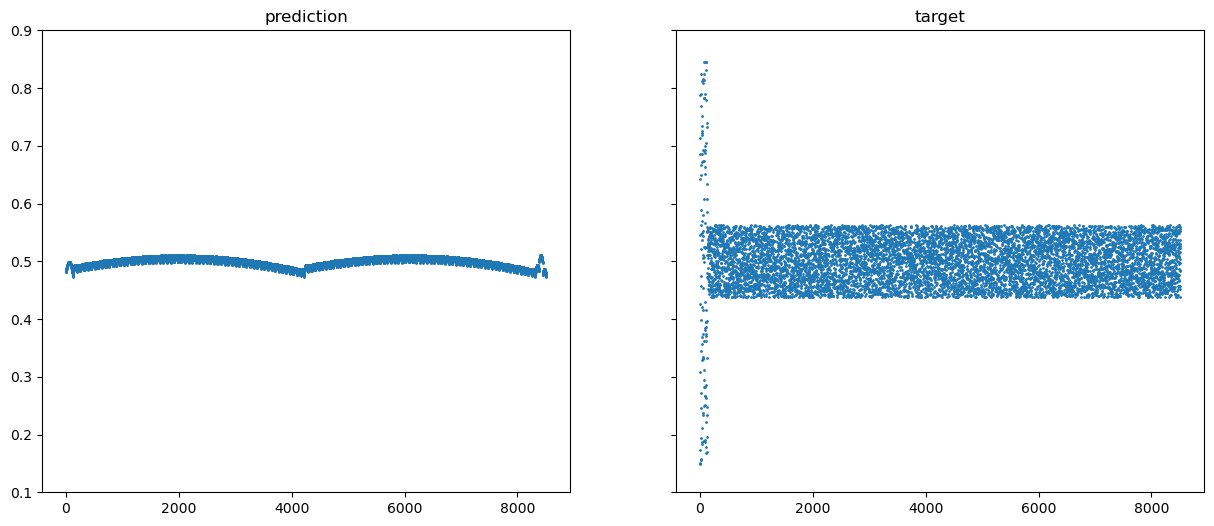

In [33]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))

ax[0].scatter(x_values, prediction.cpu().numpy(), marker='o', s=1)
ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

In [34]:
prediction.mul_(2).sub_(1)
index_tracker = 0
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith(".weight"):
            # print(param) 
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "CPPNsquared_output.pt")

128
tensor([[-0.0384, -0.0346],
        [-0.0360, -0.0324],
        [-0.0337, -0.0304],
        [-0.0315, -0.0284],
        [-0.0294, -0.0266],
        [-0.0273, -0.0247],
        [-0.0253, -0.0230],
        [-0.0234, -0.0213],
        [-0.0216, -0.0197],
        [-0.0198, -0.0182],
        [-0.0181, -0.0167],
        [-0.0165, -0.0154],
        [-0.0150, -0.0141],
        [-0.0136, -0.0129],
        [-0.0122, -0.0117],
        [-0.0109, -0.0107],
        [-0.0098, -0.0097],
        [-0.0086, -0.0088],
        [-0.0076, -0.0080],
        [-0.0067, -0.0072],
        [-0.0058, -0.0066],
        [-0.0050, -0.0060],
        [-0.0043, -0.0055],
        [-0.0037, -0.0051],
        [-0.0031, -0.0047],
        [-0.0027, -0.0045],
        [-0.0023, -0.0043],
        [-0.0020, -0.0042],
        [-0.0018, -0.0042],
        [-0.0017, -0.0042],
        [-0.0017, -0.0044],
        [-0.0017, -0.0046],
        [-0.0019, -0.0049],
        [-0.0021, -0.0053],
        [-0.0024, -0.0058],
        [-0.0028